In [1]:
#ref# https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py

# Comparing anomaly detection algorithms for outlier detection on 2D toy datasets


This example shows characteristics of different anomaly detection algorithms
on 2D datasets. Datasets contain one or two modes (regions of high density)
to illustrate the ability of algorithms to cope with multimodal data.

For each dataset, 15% of samples are generated as random uniform noise. 
Decision boundaries between inliers and outliers are displayed in black
except for Local Outlier Factor (LOF) and Unsupervised Sparse Projection 
Oblique Randomer Forests (USPORF) as it has no predict method to be applied
on new data when it is used for outlier detection. In the example, Extended Isolation Forest (EIF) and USPORF are not yet in the sklearn yet. This experiment uses adjusted rand index to compare the each outlier prediction performance.

The [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) is known to be sensitive to outliers and
thus does not perform very well for outlier detection. This estimator is best
suited for novelty detection when the training set is not contaminated by
outliers. That said, outlier detection in high-dimension, or without any
assumptions on the distribution of the inlying data is very challenging, and a
One-class SVM might give useful results in these situations depending on the
value of its hyperparameters.

[`sklearn.covariance.EllipticEnvelope`](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) assumes the data is Gaussian and
learns an ellipse. It thus degrades when the data is not unimodal. Notice
however that this estimator is robust to outliers.

[`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest), 
[`Extended Isolation Forest`](https://github.com/sahandha/eif/blob/master/eif.py),
and [`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) seem to perform reasonably well
for multi-modal data sets. The advantage of
[`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor) over the other estimators is
shown for the third data set, where the two modes have different densities.
This advantage is explained by the local aspect of LOF, meaning that it only
compares the score of abnormality of one sample with the scores of its
neighbors.
sdaasdasdadad

[`USPORF`](https://github.com/neurodata/SPORF/blob/7c4cff4/Python/rerf/urerf.py#L12) seems to better suit novelty detection because it measure the sum roll of similarity matrix. The algorithm sometimes assigns a close group of outliers as inliers.)

Finally, for the last data set, it is hard to say that one sample is more
abnormal than another sample as they are uniformly distributed in a
hypercube. Except for the [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM) which overfits a
little, all estimators present decent solutions for this situation. In such a
case, it would be wise to look more closely at the scores of abnormality of
the samples as a good estimator should assign similar scores to all the
samples.

While these examples give some intuition about the algorithms, this
intuition might not apply to very high dimensional data.

Finally, note that parameters of the models have been here handpicked but
that in practice they need to be adjusted. In the absence of labelled data,
the problem is completely unsupervised so model selection can be a challenge.

Automatically created module for IPython interactive environment


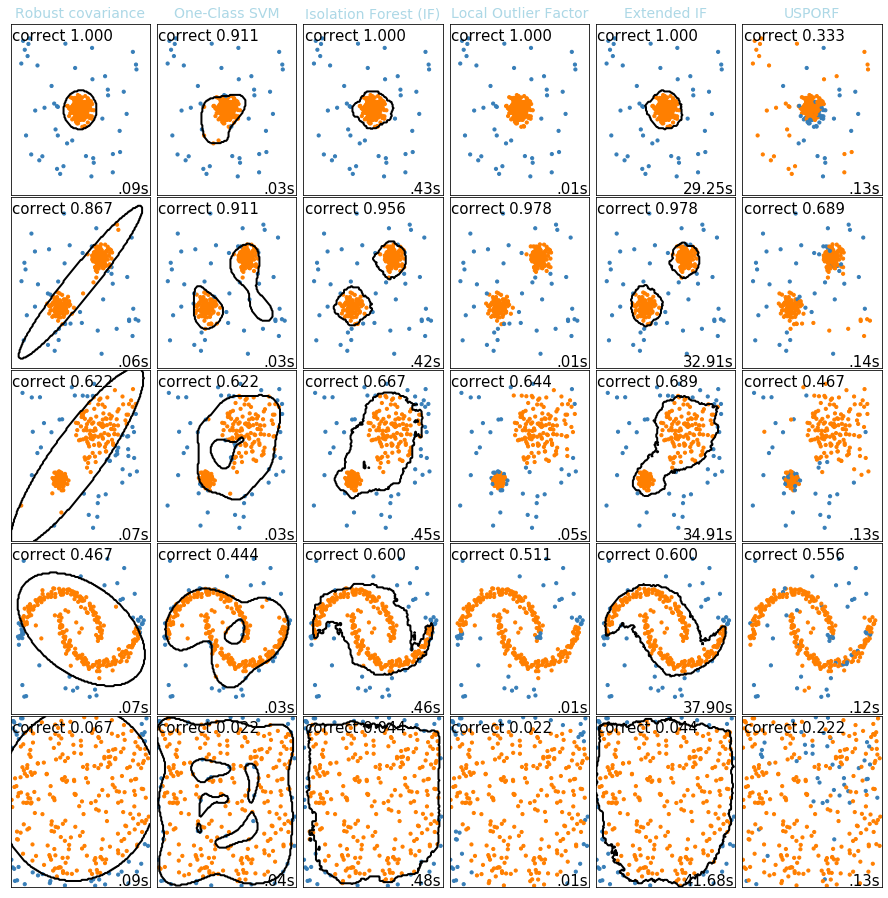

In [27]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#         Albert Thomas <albert.thomas@telecom-paristech.fr>
# Editing: adding EIF, USPORF, and noise-dimension
# License: BSD 3 clause

import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from rerf.urerf import UnsupervisedRandomForest 
import eif as iso
from sklearn.metrics import adjusted_rand_score


print(__doc__)

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

# Example settings
D_noise = 0                                                             # number of uniform noise dimension
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5,
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5],
               **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, .3],
               **blobs_params)[0],
    4. * (make_moons(n_samples=n_inliers, noise=.05, random_state=0)[0] -
          np.array([0.5, 0.25])),
    14. * (np.random.RandomState(42).rand(n_inliers, 2) - 0.5)]

# Define to data label
labels = np.concatenate([np.ones(n_inliers),-np.ones(n_outliers)], axis=0)  # lbel 1 as inliers, -1 as outliers

# define outlier/anomaly detection methods to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf",
                                      gamma=0.1)),
    ("Isolation Forest (IF)", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=35, contamination=outliers_fraction)),
    ("Extended IF", iso.iForest(datasets[0], ntrees=100, sample_size=255, ExtensionLevel=1)),
    ("USPORF",UnsupervisedRandomForest(feature_combinations='auto', max_depth=None,
                         max_features='auto', min_samples_split='auto',
                         n_estimators=100, n_jobs=None,
                         projection_matrix='RerF'))] 

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 1.6 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers (i = index (0,1,..), X = data set)
    X = np.concatenate([X, rng.uniform(low=-6, high=6,
                       size=(n_outliers, 2))], axis=0)                  # add uniform outlier
    X_noise =rng.uniform(low=-6, high=6,size=(n_samples, D_noise))      # add uniform noise dimension
    X = np.append(X, X_noise, axis=1)
    
    for name, algorithm in anomaly_algorithms: 
        # name ="USPORF", algorithm =  UnsupervisedRandomForest(_,_,_)
        t0 = time.time()
        if name == "Extended IF":                                       # Extended IF doesn't has fit function
            algorithm = iso.iForest(X, ntrees=100, sample_size=min(256,len(X)), ExtensionLevel=D_noise+1)
        else:
            algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14, color = 'lightblue') # function "name" to be title

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        elif name == "Extended IF":                                     # Extended IF doesn't have predict function
            Score = algorithm.compute_paths(X_in=X)                     # compute anomaly score
            sE = np.argsort(Score)
            indicesE = sE[-int(np.ceil(outliers_fraction*X.shape[0])):] # outlier indices 
            y_pred = np.ones(X.shape[0])
            y_pred[indicesE] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
            
            # Separation score 
            Score0= (Score[sE[-int(np.ceil(outliers_fraction*X.shape[0]))]]+Score[sE[-int(np.ceil(outliers_fraction*X.shape[0]))-1]])/2
            
        elif name == "USPORF":                                          # USPORF doesn't have predict function
            sim_mat = algorithm.transform()                             # create similarity matrix
            sim_sum = sim_mat.sum(axis=1)                               
            sU = np.argsort(sim_sum)
            indicesU = sU[:int(np.floor(outliers_fraction*X.shape[0]))] # outlier indeces
            y_pred = np.ones(X.shape[0])
            y_pred[indicesU] = -1
            y_pred = y_pred.astype(int)                                 # convert float to int array
        else:
            y_pred = algorithm.fit(X).predict(X)
            
        #calculate % correction score
        count_correct = list(y_pred + labels)
        score = count_correct.count(-2)/n_outliers
            
        # plot the levels lines and the points (only for 2D data)
        if D_noise == 0:
            if name in ("Robust covariance","One-Class SVM","Isolation Forest (IF)"):
                Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
            if name == "Extended IF":
                Z_Score = algorithm.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()]) 
                Z = np.ones(np.c_[xx.ravel(), yy.ravel()].shape[0])
                for index, element in enumerate(Z_Score):                  # If the element in Z_score >= Score0, assign it to be an outlier
                    if element >= Score0:
                        Z[index]=-1
                Z = Z.astype(int)
                Z = Z.reshape(xx.shape)
                plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
        t2 = time.time()    
        colors = np.array(['#377eb8', '#ff7f00'])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[((y_pred + 1) // 2)]) # label color

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t2 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')                         # Calculation time
        plt.text(.01, .9, ('correct %.3f' % score).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='left')                          # ARI score
        plot_num += 1

plt.show()

In [ ]:
# Next Step
# # PR to USPORF: 
#     - adding column of EIF, USPORF
#     - adding 3D data generator example (paper: Geodesic/ USPORF)
    
# # PR to SKlearm
#     - adding noise dimension choice
#     - adding 3D data generator example (paper: Geodesic/ USPORF)
    
# # Semester Spring Goal
#     - apply Shumin's path length in USPORF